# Setup and imports

In [ ]:
# TODO Install Augmend module in venv pip install git+https://github.com/stardist/augmend.git
# https://github.com/stardist/augmend (STARDIST)
# You might need to install git in your venv using mamba install git

In [1]:
# Checking Python version
import platform
print(platform.python_version())

3.9.19


In [2]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tifffile
from pathlib import Path
from tqdm import tqdm
import czifile
from csbdeep.utils import normalize

# Input image and ground truth label loader 

In [24]:
img_directory = Path("Zeiss_Raw_Images")
label_directory = Path('ground_truth_labels')

In [4]:
%ls {img_directory} #Check if input images are accesible

 Volume in drive C is OS
 Volume Serial Number is 9249-36E0

 Directory of c:\Users\adiez_cmic\github_repos\UNet_SemSeg_healthy_tumor_SRs\Zeiss_Raw_Images

06/05/2024  10:04 AM    <DIR>          .
06/05/2024  10:15 AM    <DIR>          ..
06/05/2024  09:56 AM       223,016,064 1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
06/05/2024  09:43 AM       394,013,760 1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
06/05/2024  09:43 AM       357,357,088 1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
06/05/2024  09:43 AM       321,772,256 1837I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
06/05/2024  09:56 AM       144,293,120 1849I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
06/05/2024  09:43 AM       223,987,072 1851I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
               6 File(s)  1,664,439,360 bytes

 Directory of c:\Users\adiez_cmic\github_repos\UNet_SemSeg_healthy_tumor_SRs


 Directory of c:\Users\adiez_cmic\github_repos\UNet_SemSeg_healthy_tumor_SRs


 Directory of c:\Users\adiez_cmic\github_repos\UNet_SemSeg_healt

File Not Found


In [25]:
%ls {label_directory} #Check if input images are accesible

 Volume in drive C is OS
 Volume Serial Number is 9249-36E0

 Directory of c:\Users\adiez_cmic\github_repos\UNet_SemSeg_healthy_tumor_SRs\ground_truth_labels

06/05/2024  10:24 AM    <DIR>          .
06/05/2024  10:15 AM    <DIR>          ..
06/05/2024  10:07 AM        49,123,817 1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Background.ome.tiff
06/05/2024  10:07 AM        52,471,204 1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Healthy.ome.tiff
06/05/2024  10:07 AM            49,105 1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Tumor.ome.tiff
06/05/2024  10:07 AM        86,593,850 1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Background.ome.tiff
06/05/2024  10:07 AM        86,593,847 1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Healthy.ome.tiff
06/05/2024  10:07 AM        88,217,892 1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Tumor.ome.tiff
06/05/2024  10:07 AM        78,766,010 1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Background.ome.tiff
06/05/2024  10:07 AM        78,766,007 1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Healthy.om

File Not Found


In [26]:
f_images = sorted(img_directory.glob("*.czi"))
f_masks = sorted(label_directory.glob("*.tiff"))
print(f'Found {len(f_images)} images and {len(f_masks)} masks')

Found 6 images and 18 masks


In [8]:
# Input image loader (.czi files)
def read_image(fname):
    x = czifile.imread (fname)
    x = np.squeeze(x, axis=3)
    x = np.moveaxis(x, 0, -1)
    return x

imgs = tuple(normalize(read_image(f), axis=(0,1)) for f in tqdm(f_images))

100%|██████████| 6/6 [00:27<00:00,  4.65s/it]


In [27]:
# Ground truth label loader (ome.tiff files)
raw_masks = tuple(tifffile.imread(f) for f in tqdm(f_masks))

100%|██████████| 18/18 [00:00<00:00, 47.61it/s]


# Fixing overlapping pixels in between classes

In [28]:
def check_overlap(r1,r2,r3):
    '''Checks overlaps in between all 3 different class labels using a numpy logical operator
    and outputs a boolean'''
    print (f"\nBackground and Healthy share pixels: {str(np.logical_and(r1,r2).any())}")
    print (f"Background and Tumor share pixels: {str(np.logical_and(r1,r3).any())}")
    print (f"Healthy and Tumor share pixels: {str(np.logical_and(r2,r3).any())}")

masks = []
bh_shared = []
bt_shared = []
ht_shared = []

def fix_overlap(raw_masks, masks, bh_shared, bt_shared, ht_shared, f_masks):
    '''Iterates over the masks(arrays) in groups of 3 (background, healthy, tumor), finds shared positions
    among them and substitutes them for 0s in the original array, finally it appends the modified arrays
    into a masks list'''
    index = 0 #Just an index to keep track of the sample we are processing the labels for
    
    for r1, r2, r3 in zip(raw_masks[::3], raw_masks[1::3], raw_masks[2::3]):
        
        # -------------------------
        # Check if r1 and r2 share positive values at the same position (background and healthy)
        if np.logical_and(r1,r2).any():
            shared_positions = np.logical_and(r1 > 0, r2 > 0)
            # Modify positions to have a value of 0 in r1 and r2
            r1[shared_positions] = 0
            r2[shared_positions] = 0
            # Generate r4 with a value of 255 in shared positions
            r4 = np.zeros_like(r1)
            r4[shared_positions] = 255
        else:
            r4 = np.zeros_like(r1)
        # Append r4 to bh_shared
        bh_shared.append(r4)
        
        # -------------------------
        # Check if r1 and r3 share positive values at the same position (background and healthy)
        if np.logical_and(r1,r3).any():
            shared_positions = np.logical_and(r1 > 0, r3 > 0)
            # Modify positions to have a value of 0 in r1 and r2
            r1[shared_positions] = 0
            r3[shared_positions] = 0
            # Generate r4 with a value of 255 in shared positions
            r4 = np.zeros_like(r1)
            r4[shared_positions] = 255
        else:
            r4 = np.zeros_like(r1)
        # Append r4 to bh_shared
        bt_shared.append(r4)
        
        # -------------------------
        # Check if r2 and r3 share positive values at the same position (background and healthy)
        if np.logical_and(r2,r3).any():
            shared_positions = np.logical_and(r2 > 0, r3 > 0)
            # Modify positions to have a value of 0 in r1 and r2
            r2[shared_positions] = 0
            r3[shared_positions] = 0
            # Generate r4 with a value of 255 in shared positions
            r4 = np.zeros_like(r1)
            r4[shared_positions] = 255
        else:
            r4 = np.zeros_like(r1)
        # Append r4 to bh_shared
        ht_shared.append(r4)

        # --------------------------
        # Displays the results of fixing the overlapping pixel values
        print("\nFixing overlap results: \n")
        print(f_masks[index].name.replace('_Background.ome.tiff', ''))
        check_overlap(r1,r2,r3) #Checks if different class labels overlap

        # --------------------------
        # Adds the new arrays without overlapping pixels between classes into a list
        u = np.stack((r1>0, r2>0, r3>0), -1).astype(np.float32) # Create a numpy.ndarray of shape (px height, px width, 3)
        print(f"Output mask array: {u.shape} \n")
        masks.append(u) # Appends the array to the masks list
        
        index += 3 # Update the index to keep track of the sample position
                
    return masks, bh_shared, bt_shared, ht_shared
    

In [29]:
fix_overlap(raw_masks, masks, bh_shared, bt_shared, ht_shared, f_masks)
del raw_masks # Remove raw_masks variable to free up memory


Fixing overlap results: 

1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (6561, 7479, 3) 


Fixing overlap results: 

1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (9315, 9288, 3) 


Fixing overlap results: 

1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (8424, 9342, 3) 


Fixing overlap results: 

1837I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (8424, 8397, 3) 


Fixing overlap results: 

1849I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share 

In [12]:
# Checking how many pixels overlaped in between classes (bh_shared, bt_shared, ht_shared)
for i, array in enumerate(ht_shared):
    print(f"Array {i}")
    unique_values, value_counts = np.unique(array, return_counts=True)
    # Print the unique values and their counts
    for value, count in zip(unique_values, value_counts):
        print(f"Value: {value}, Count: {count}")

Array 0
Value: 0, Count: 49069719
Array 1
Value: 0, Count: 86516785
Value: 255, Count: 935
Array 2
Value: 0, Count: 78695868
Value: 255, Count: 1140
Array 3
Value: 0, Count: 70735627
Value: 255, Count: 701


# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


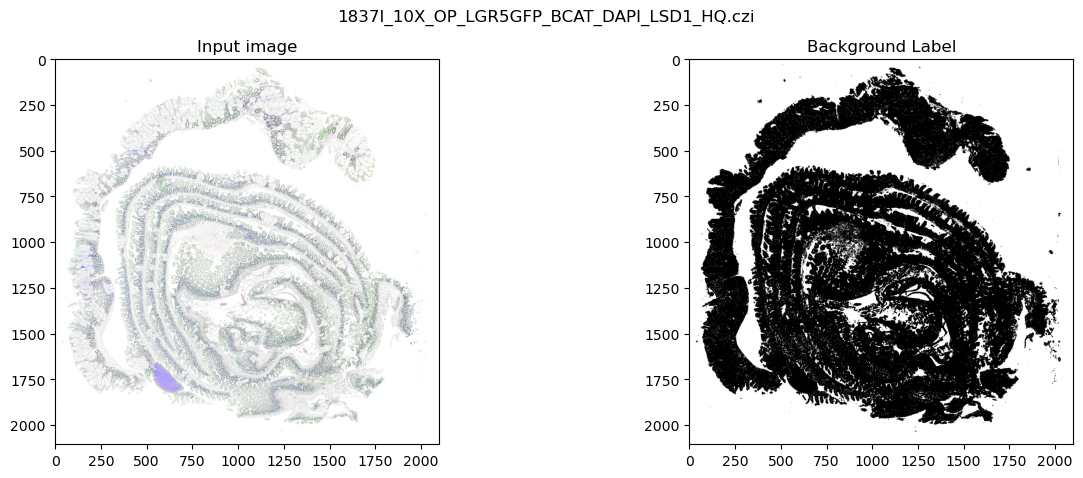

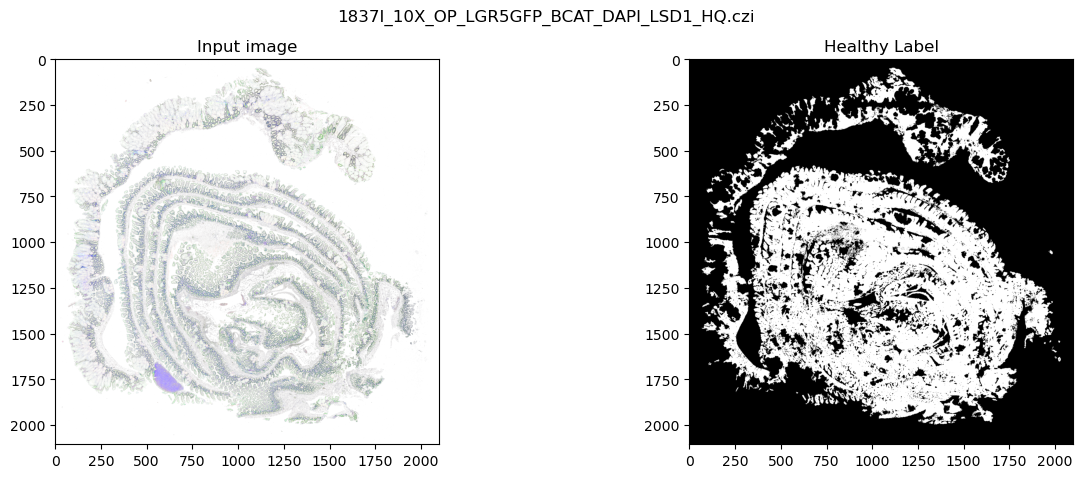

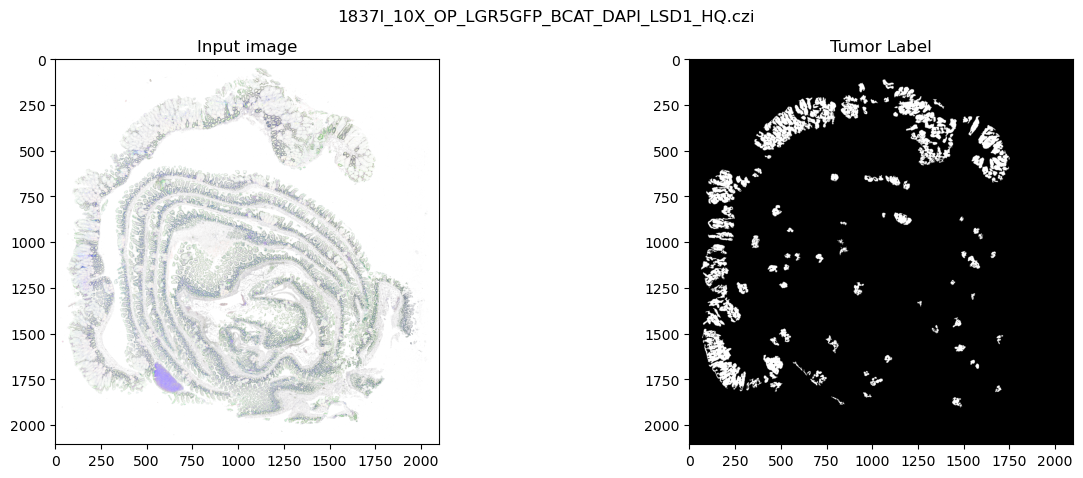

In [13]:
# Plot an example image and all of its segmentation masks
i = 3 #Define the position of the sample in the array

graph_title = ["Background", "Healthy", "Tumor"]

for mask_nr in range(3):
    fig, (a0,a1) = plt.subplots(1,2,figsize=(15,5))
    a0.imshow(imgs[i][::4,::4]); #plot every 4th pixel (subsampling)
    a0.set_title('Input image')
    a1.imshow(masks[i][::4,::4,mask_nr], cmap='gray'); #plot every 4th pixel (subsampling)                    
    a1.set_title(f"{graph_title[mask_nr]} Label")
    fig.suptitle(f_images[i].name)
    # plt.savefig(fname=f"prediction_tiffs/{f_images[i].name}.{graph_title[mask_nr]}.png", dpi=300, format='png')
    None;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


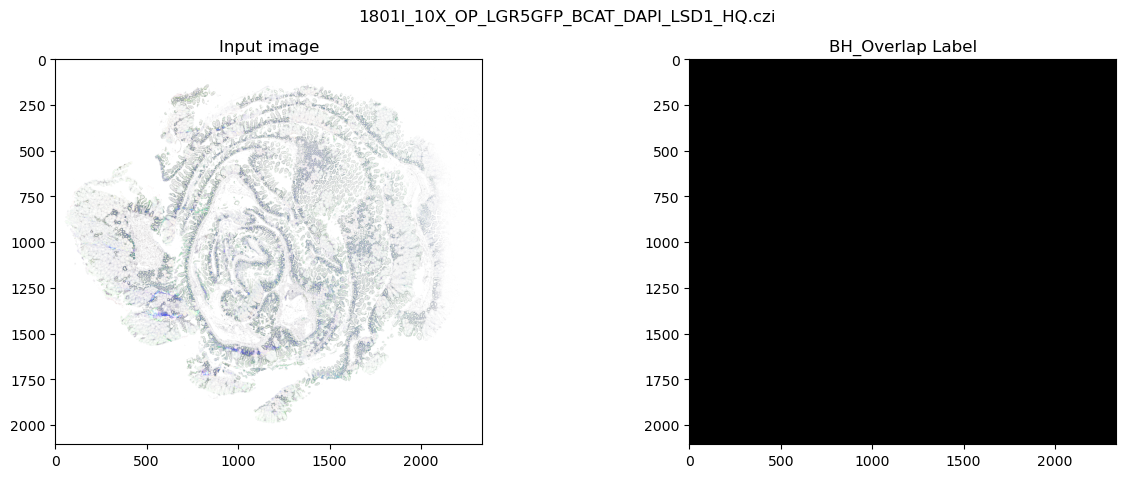

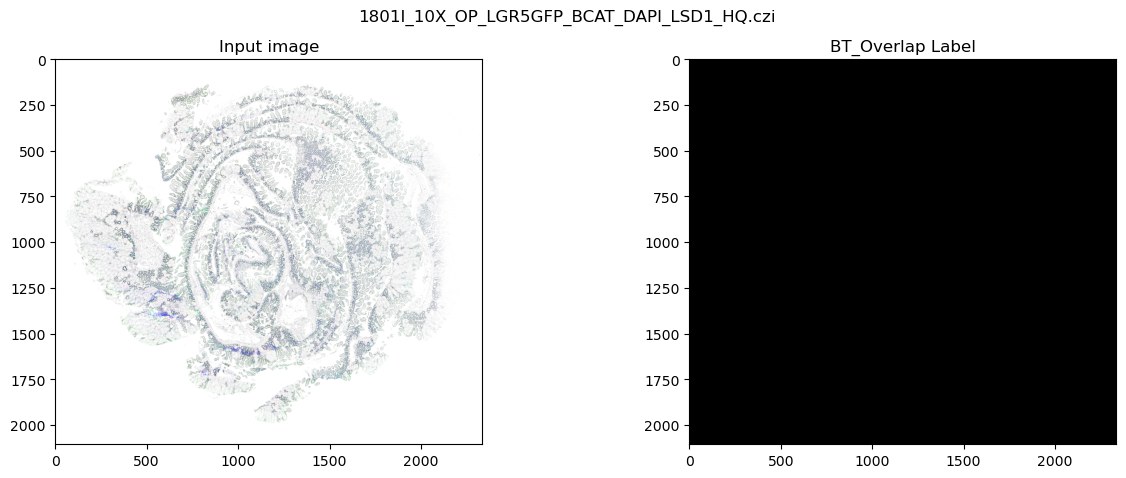

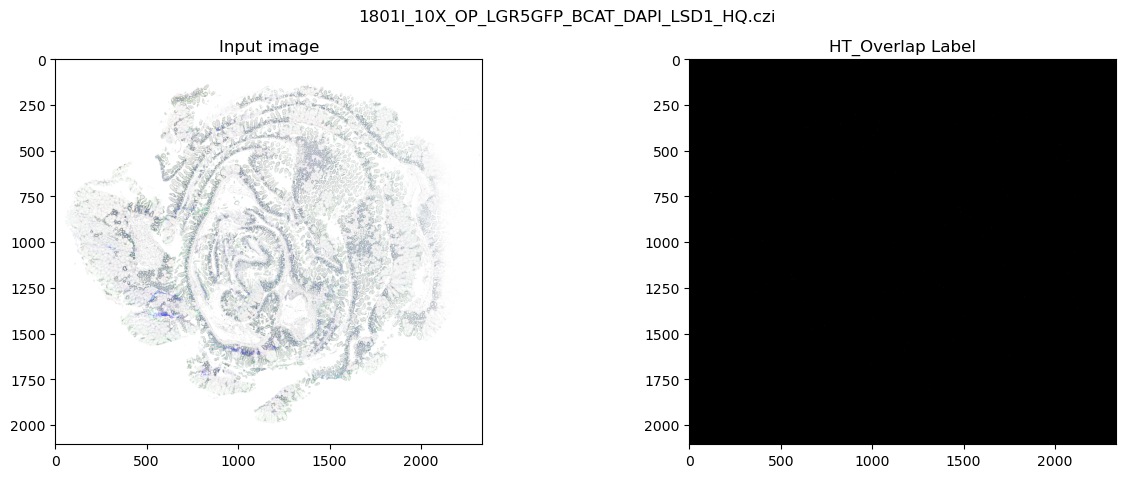

In [14]:
# Plot where labels where overlapping, hard to visualize since there were only around 0.1% overlapping
i = 2 #Define the position of the sample in the array
overlap_graph_title = ["BH_Overlap","BT_Overlap","HT_Overlap"]
overlap_list = [bh_shared, bt_shared, ht_shared]

for overlap_mask_nr in range(3):
    fig, (a0,a1) = plt.subplots(1,2,figsize=(15,5))
    a0.imshow(imgs[i][::4,::4]); #plot every 4th pixel (subsampling)
    a0.set_title('Input image')
    a1.imshow(overlap_list[overlap_mask_nr][i][::4,::4], cmap='gray'); #plot every 4th pixel (subsampling)                    
    a1.set_title(f"{overlap_graph_title[overlap_mask_nr]} Label")
    fig.suptitle(f_images[i].name)
    # plt.savefig(fname=f"background_shared/{f_images[i].stem}.{overlap_graph_title[overlap_mask_nr]}.png", dpi=300, format='png')
    None;

# Train and validation dataset definition

In [30]:
# Using list slicing to leave 2 validation images one with and one without tumors (at index 3 and 5)
# By specifying dtype=object np allows for the creation of an ndarray that can store arrays with different shapes
imgs_array = np.asarray(imgs, dtype=object)
masks_array = np.asarray(masks, dtype=object)
train_index = [0, 1, 2, 4]
val_index = [3, 5]

X = tuple(imgs_array[train_index]) # Training inputs (features)
Y = list(masks_array[train_index]) # Training labels (target)

Xv = tuple(imgs_array[val_index]) # Validation inputs (features)
Yv = list(masks_array[val_index]) # Validation labels (target)

print(f"X: {len(X)}, Y: {len(Y)}, Xv: {len(Xv)}, Yv: {len(Yv)}")

X: 4, Y: 4, Xv: 2, Yv: 2


# Model (U-net)

In [15]:
# !rm model.py && wget https://raw.githubusercontent.com/maweigert/tutorials/main/unet_2d/model.py --no-cache -O model.py

In [31]:
import model as M

In [32]:
n_dim=2

conf = M.UNetConfig(n_dim=n_dim,
                  n_channel_in = 4,
                  n_channel_out = 3,
                  patch_size=(512,512),
                  train_batch_size=4,
                  train_class_weight = (1,1,1))

In [33]:
vars(conf)

{'n_dim': 2,
 'axes': 'XYC',
 'n_channel_in': 4,
 'n_channel_out': 3,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'softmax',
 'unet_input_shape': (None, None, 4),
 'train_loss': 'categorical_crossentropy',
 'train_epochs': 100,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0},
 'train_class_weight': (1, 1, 1),
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'patch_size': (512, 512)}

In [34]:
model = M.UNet(conf, 'model1_epoch10', basedir='models')

In [35]:
model.train(X, Y, Xv, Yv, epochs=10, steps_per_epoch=16)

Epoch 1/10
16/16 [==============================] - 38s 101ms/step - loss: 0.9266 - metric_precision: 0.4113 - metric_recall: 0.1797 - metric_f1: 0.2013 - val_loss: 0.4844 - val_metric_precision: 0.8850 - val_metric_recall: 0.8025 - val_metric_f1: 0.8417 - lr: 4.0000e-04
Epoch 2/10
16/16 [==============================] - 1s 62ms/step - loss: 0.3241 - metric_precision: 0.8409 - metric_recall: 0.8752 - metric_f1: 0.8573 - val_loss: 0.2345 - val_metric_precision: 0.8846 - val_metric_recall: 0.9235 - val_metric_f1: 0.9036 - lr: 4.0000e-04
Epoch 3/10
16/16 [==============================] - 1s 61ms/step - loss: 0.2134 - metric_precision: 0.8818 - metric_recall: 0.9022 - metric_f1: 0.8916 - val_loss: 0.2043 - val_metric_precision: 0.9017 - val_metric_recall: 0.9339 - val_metric_f1: 0.9175 - lr: 4.0000e-04
Epoch 4/10
16/16 [==============================] - 1s 61ms/step - loss: 0.1834 - metric_precision: 0.8838 - metric_recall: 0.9153 - metric_f1: 0.8988 - val_loss: 0.2095 - val_metric_preci

# Apply the model on a test image

In [36]:
test_img_directory = Path("Zeiss_Raw_Test")
!ls {test_img_directory} #Check if input images are accesible
f_test_images = sorted(test_img_directory.glob("*.czi"))
print(f'found {len(f_test_images)} test images')

test_imgs = tuple(normalize(read_image(f), axis=(0,1)) for f in tqdm(f_test_images))

'ls' is not recognized as an internal or external command,
operable program or batch file.


found 7 test images


100%|██████████| 7/7 [00:25<00:00,  3.71s/it]


In [37]:
model

UNet(model1_epoch10): XYC → XYC
├─ Directory: C:\Users\adiez_cmic\github_repos\UNet_SemSeg_healthy_tumor_SRs\models\model1_epoch10
└─ UNetConfig(n_dim=2, axes='XYC', n_channel_in=4, n_channel_out=3, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=False, unet_n_depth=2, unet_kern_size=3, unet_n_first=32, unet_last_activation='softmax', unet_input_shape=(None, None, 4), train_loss='categorical_crossentropy', train_epochs=100, train_steps_per_epoch=400, train_learning_rate=0.0004, train_batch_size=4, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0, 'verbose': True}, train_class_weight=(1, 1, 1), unet_batch_norm=False, unet_dropout=0.0, patch_size=(512, 512))

In [38]:
predictions = []
for img in test_imgs:
    prediction = model.predict(img, axes='XYC', n_tiles=(8,8,1))
    predictions.append(prediction)
    print(prediction.shape)

c:\Users\adiez_cmic\miniforge3\envs\EMBL_tensorflow\lib\site-packages\csbdeep\models\base_model.py:311: UserWarning: skipping normalization step after prediction because number of input and output channels differ.
  warnings.warn('skipping normalization step after prediction because ' +
100%|██████████| 64/64 [00:03<00:00, 17.44it/s]


(7479, 7506, 3)


100%|██████████| 64/64 [00:03<00:00, 17.65it/s]


(7479, 7479, 3)


100%|██████████| 64/64 [00:03<00:00, 18.72it/s]


(5670, 8397, 3)


100%|██████████| 64/64 [00:03<00:00, 17.43it/s]


(7506, 7506, 3)


100%|██████████| 64/64 [00:03<00:00, 21.31it/s]


(6561, 5616, 3)


100%|██████████| 64/64 [00:03<00:00, 18.79it/s]


(6588, 7479, 3)


100%|██████████| 64/64 [00:03<00:00, 19.86it/s]

(6561, 6561, 3)


In [39]:
len(predictions)

7

0it [00:00, ?it/s]

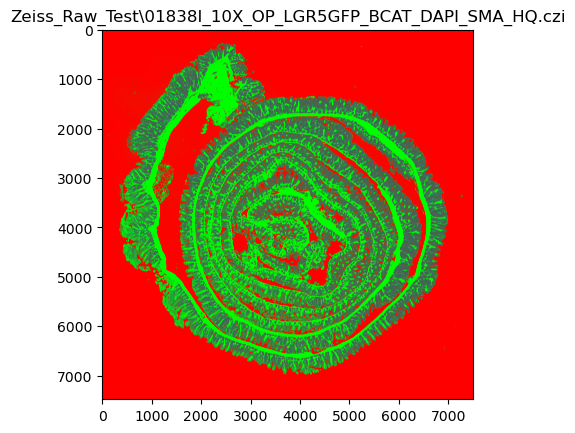

1it [00:02,  2.48s/it]

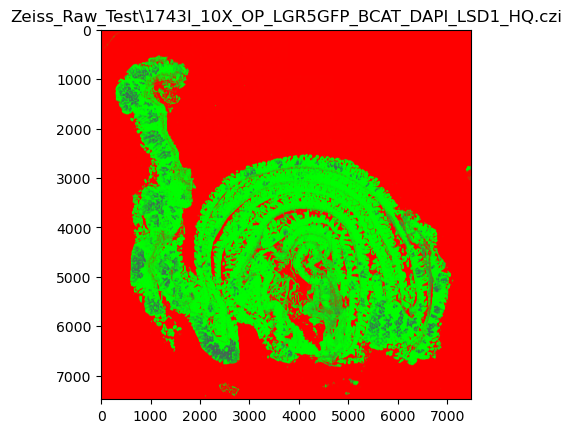

2it [00:05,  2.54s/it]

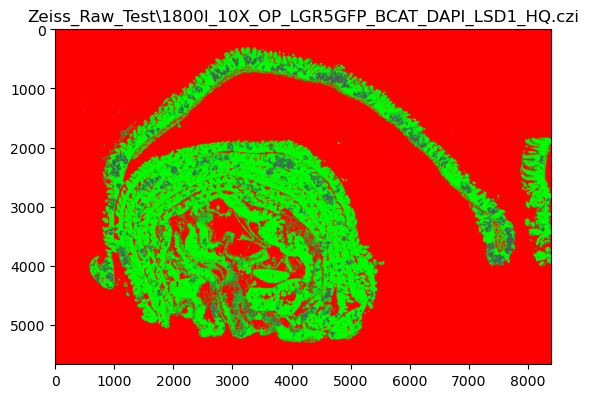

3it [00:07,  2.48s/it]

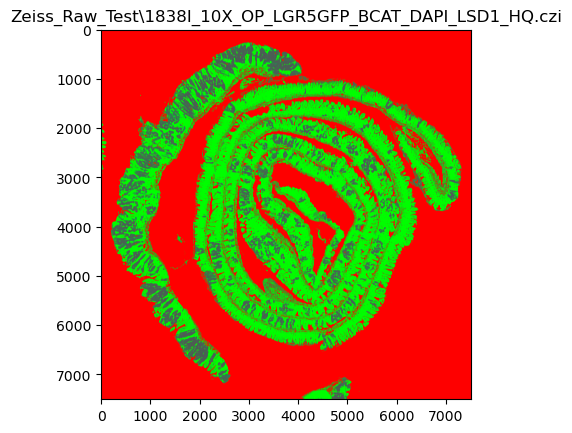

4it [00:09,  2.44s/it]

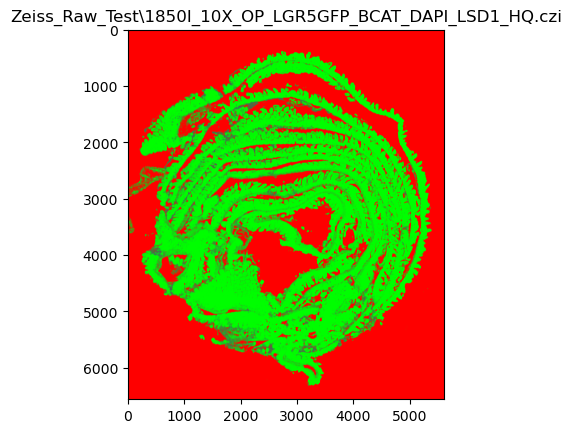

5it [00:11,  2.16s/it]

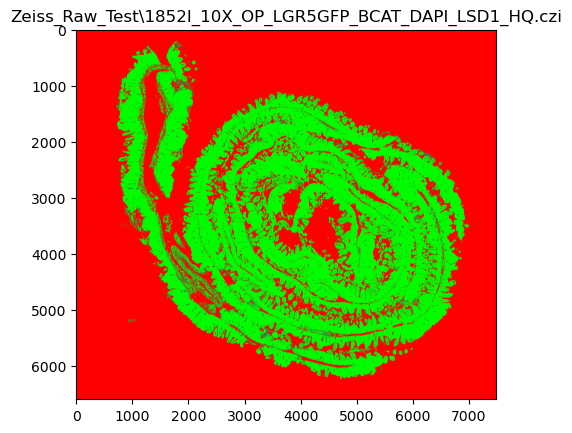

6it [00:13,  2.22s/it]

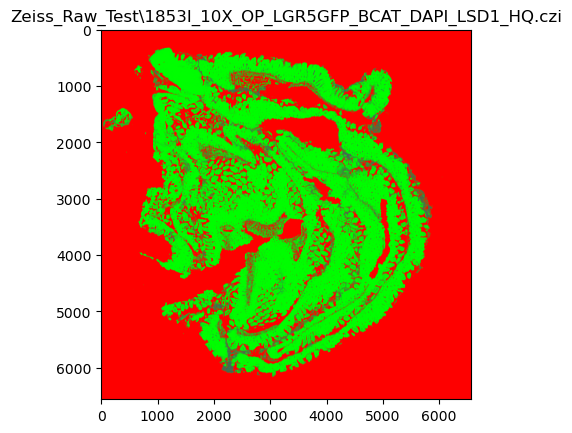

7it [00:15,  2.26s/it]


In [40]:
for i, img in tqdm(enumerate(predictions)):
    plt.imshow(img)
    plt.title(f_test_images[i])
    plt.show()